# 1D parameter estimation using MCMC

This example will cover:

 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions


In [1]:
from gptide import cov
from gptide import GPtideScipy
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats
from gptide import stats as gpstats

## Generate some data

Start off with the same kernel as Example 1 and generate some data.

In [2]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
η = 1.5
ℓ = 100
covfunc = cov.expquad_1d

###
# Domain size parameters
dx = 25.
N = 100
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)


Text(0.5, 0, 'x')

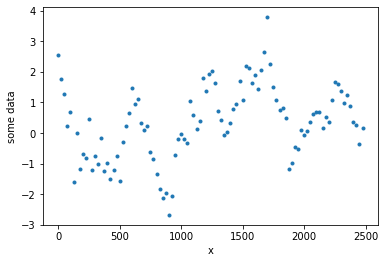

In [3]:
plt.figure()
plt.plot(xd, yd,'.')
plt.ylabel('some data')
plt.xlabel('x')

## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [4]:
from gptide import mcmc
import importlib
importlib.reload(mcmc)

<module 'gptide.mcmc' from 'c:\\users\\azulberti\\dropbox\\university\\phd\\03_code\\source_code\\gptide\\gptide\\mcmc.py'>

In [5]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(0.4, 0.25, 1e-15, 1e2)                 # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(1, 1, 1e-15, 1e2),   # η - true value 1.5
#                     gpstats.truncnorm(10, 1, 1e-15, 1e4) # ℓ - true value 100
                    gpstats.truncnorm(125, 50, 1e-15, 1e4)  # ℓ - true value 100
                   ]

samples, log_prob, priors_out, sampler = mcmc.mcmc( xd, 
                                                    yd, 
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=20,
                                                    niter=20,
                                                    verbose=False)



Running burn-in...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.53it/s]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.48it/s]


## Find sample with highest log prob

In [6]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f}, Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('ℓ (true): {:3.2f}, ℓ (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('η (true): {:3.2f}, η (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))


Noise (true): 0.50, Noise (mcmc): 0.46
ℓ (true): 1.50, ℓ (mcmc): 2.12
η (true): 100.00, η (mcmc): 108.50


## Posterior density plot

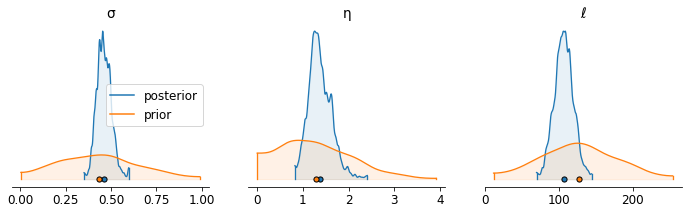

In [7]:
labels = ['σ','η','ℓ']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 3),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

## Posterior corner plot

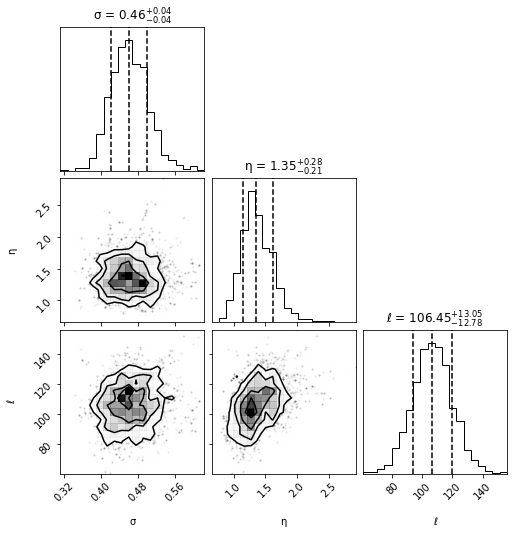

In [8]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

In [9]:
xo = np.arange(0,dx*N,dx/3)[:,None]

OI = GPtideScipy(xd, xo, MAP[0], covfunc, MAP[1:], 
             P=1, mean_func=None)

out_map = OI.conditional(yd)

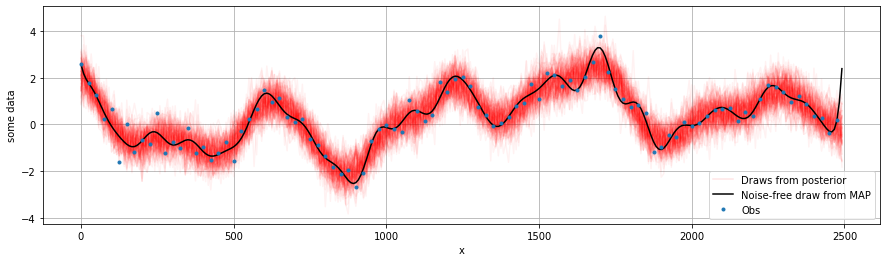

In [10]:
plt.figure(figsize=(15, 4))
plt.ylabel('some data')
plt.xlabel('x')

for i, draw in enumerate(np.random.uniform(0, samples.shape[0], 100).astype(int)):
    sample = samples[draw, :]
    OI = GPtideScipy(xd, xo, sample[0], covfunc, sample[1:], 
             P=1, mean_func=None)
    out_samp = OI.conditional(yd)
    plt.plot(xo, out_samp, 'r', alpha=0.05, label=None)
    
plt.plot(xo, out_samp, 'r', alpha=0.1, label='Draws from posterior') # Just for legend
    
OI = GPtideScipy(xd, xo, 0, covfunc, MAP[1:], 
             P=1, mean_func=None)
out_map = OI.conditional(yd)

plt.plot(xo, out_map, 'k', label='Noise-free draw from MAP')
plt.plot(xd, yd,'.', label='Obs')
plt.legend()
plt.grid()
